In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

from utils import *

/home/wanhr/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
local_ip = "10.215.173.1"
dl_pkts = np.zeros([0, 3])
ul_pkts = np.zeros([0, 3])

for i in [1]:
  filename = "~/Documents/data/cos513/5G_Traffic_Datasets/Game_Streaming/GeForce_Now/GeForce_Now_{}.csv".format(i)

  df = load_csv(filename)
  # stats_src_ip(df)
  # stats_dst_ip(df)
  dl_data = extract_dl_pkt_interval_time(df, local_ip)
  ul_data = extract_ul_pkt_interval_time(df, local_ip)
  dl_pkts = np.concatenate((dl_pkts, dl_data), axis=0)
  ul_pkts = np.concatenate((ul_pkts, ul_data), axis=0)
  print(dl_pkts.shape)
  print(ul_pkts.shape)
  # dl_pkts = extract_dl_pkt_interval_time(df, local_ip)
  # ul_pkts = extract_ul_pkt_interval_time(df, local_ip)

(4092384, 3)
(562975, 3)


In [64]:
print(dl_pkts.shape)

(4092384, 3)


In [65]:
dl_pkt_interval = dl_pkts[dl_pkts[:, 0] < 0.05, :]
ul_pkt_interval = ul_pkts[ul_pkts[:, 0] < 0.05, :]

dl_pkt_interval[:, 0] = dl_pkt_interval[:, 0] * 1000
ul_pkt_interval[:, 0] = ul_pkt_interval[:, 0] * 1000

dl_count, dl_bins_count = np.histogram(dl_pkt_interval[:, 0], bins=1000) 
dl_pdf = dl_count / sum(dl_count) 
dl_cdf = np.cumsum(dl_pdf) 

ul_count, ul_bins_count = np.histogram(ul_pkt_interval[:, 0], bins=1000) 
ul_pdf = ul_count / sum(ul_count) 
ul_cdf = np.cumsum(ul_pdf) 

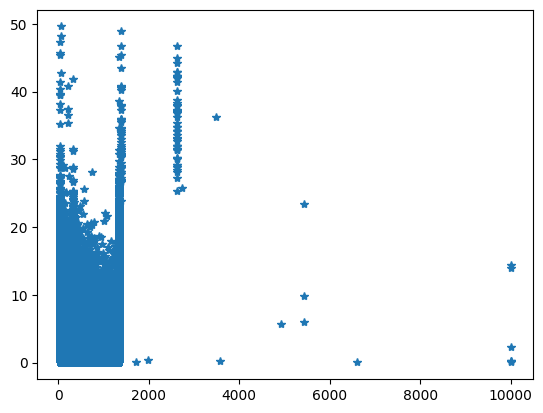

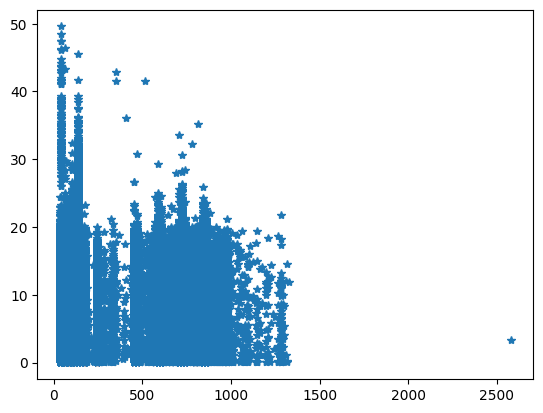

In [66]:
plt.figure()
plt.plot(dl_pkt_interval[:, 2], dl_pkt_interval[:, 0], '*')

plt.figure()
plt.plot(ul_pkt_interval[:, 2], ul_pkt_interval[:, 0], "*")

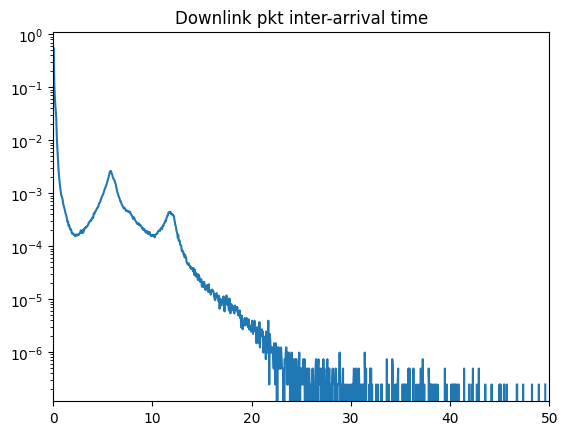

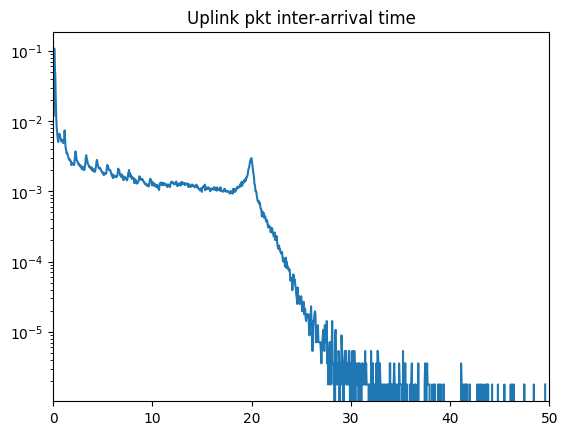

In [81]:
plt.figure()
plt.plot(dl_bins_count[1:], dl_pdf)
plt.xlim([0, 50])
plt.yscale("log")
plt.title("Downlink pkt inter-arrival time")

plt.figure()
plt.plot(ul_bins_count[1:], ul_pdf)
plt.xlim([0, 50])
plt.yscale("log")
plt.title("Uplink pkt inter-arrival time")

plt.show()

In [68]:
train = torch.tensor(dl_pkt_interval, dtype=torch.float)
pkt_interval, time, pkt_size = train[:, 0], train[:, 1], train[:, 2]

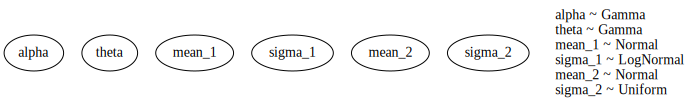

In [69]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

# def categorical_possion()

def model(pkt_size, pkt_interval=None):
    alpha = pyro.sample("alpha", dist.Gamma(1., 1.))
    theta = pyro.sample("theta", dist.Gamma(1., 1.))
    gamma = dist.Gamma(alpha, theta)

    mean_1 = pyro.sample("mean_1", dist.Normal(5, 2))
    sigma_1 = pyro.sample("sigma_1", dist.LogNormal(0., 0.05))
    gaussian_1 = dist.Normal(mean_1, sigma_1)

    mean_2 = pyro.sample("mean_2", dist.Normal(12, 2))
    sigma_2 = pyro.sample("sigma_2", dist.Uniform(0., 0.05))
    gaussian_2 = dist.Normal(mean_2, sigma_2)

    cat_dist = dist.OneHotCategorical(torch.Tensor([0.7, 0.2, 0.1]))
    y = cat_dist.sample()

    gamma_samp = gamma.sample()
    gaussian_samp_1 = gaussian_1.sample()
    gaussian_samp_2 = gaussian_2.sample()
    
    with pyro.plate("data", len(time)):
        return y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2

pyro.render_model(model, model_args=(pkt_size, pkt_interval), render_distributions=True)

In [70]:
def custom_guide(pkt_size, pkt_interval=None):
    alpha_alpha = pyro.param('alpha_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    alpha_theta = pyro.param('alpha_theta', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Gamma(alpha_alpha, alpha_theta))

    theta_alpha = pyro.param('theta_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    theta_theta = pyro.param('theta_theta', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    theta = pyro.sample('theta', dist.Gamma(theta_alpha, theta_theta))

    mean_1_loc = pyro.param('mean_1_loc', lambda: torch.tensor(5. ))
    sigma_1_loc = pyro.param('sigma_1_loc', lambda: torch.tensor(0.))
    mean_1 = pyro.sample('mean_1', dist.Normal(mean_1_loc, torch.tensor(0.05)))
    sigma_1 = pyro.sample('sigma_1', dist.LogNormal(sigma_1_loc, torch.tensor(0.005)))

    mean_2_loc = pyro.param('mean_2_loc', lambda: torch.tensor(12. ))
    sigma_2_loc = pyro.param('sigma_2_loc', lambda: torch.tensor(0.))
    mean_2 = pyro.sample('mean_2', dist.Normal(mean_2_loc, torch.tensor(0.05)))
    sigma_2 = pyro.sample('sigma_2', dist.LogNormal(sigma_2_loc, torch.tensor(0.005)))

    # weight_1 = pyro.param('weight_1', lambda: torch.tensor(0.9),
    #                       constraint=constraints.positive)
    # weight_2 = pyro.param('weight_2', lambda: torch.tensor(0.05),
    #                       constraint=constraints.positive)
    # weight_3 = pyro.param('weight_3', lambda: torch.tensor(0.05),
    #                       constraint=constraints.positive)
    # cat = dist.OneHotCategorical(torch.Tensor([weight_1, weight_2, weight_3]))
    # y = pyro.sample('y', cat)

    return {'alpha': alpha, 'theta': theta, 'mean_1': mean_1, 'sigma_1': sigma_1, 
            'mean_2': mean_2, 'sigma_2': sigma_2}

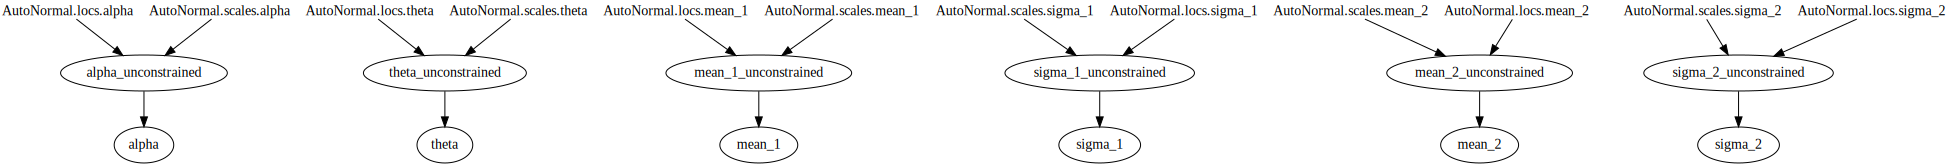

In [71]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)

pyro.render_model(auto_guide, model_args=(pkt_size, pkt_interval), render_params=True)

In [72]:
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

Step: 0, Elbo loss: 0.30059041641652584
Step: 100, Elbo loss: -0.02277480810880661
Step: 200, Elbo loss: 0.5497387638315558
Step: 300, Elbo loss: 0.7138625057414174
Step: 400, Elbo loss: -0.9967870935797691
Step: 500, Elbo loss: 1.9047563523054123
Step: 600, Elbo loss: -0.1082015372812748
Step: 700, Elbo loss: 0.32659381441771984
Step: 800, Elbo loss: -0.8573614060878754
Step: 900, Elbo loss: 0.8575878106057644
Step: 1000, Elbo loss: 1.0140180066227913
Step: 1100, Elbo loss: 0.23905091919004917
Step: 1200, Elbo loss: -0.21102098189294338
Step: 1300, Elbo loss: -0.7075046524405479
Step: 1400, Elbo loss: -0.2376963198184967
Step: 1500, Elbo loss: 1.4727182649075985
Step: 1600, Elbo loss: -0.6029610857367516
Step: 1700, Elbo loss: -0.3945513591170311
Step: 1800, Elbo loss: -0.2144928928464651
Step: 1900, Elbo loss: -0.44141413271427155
Step: 2000, Elbo loss: 0.07906586490571499
Step: 2100, Elbo loss: 1.1901528760790825
Step: 2200, Elbo loss: -0.2542938068509102
Step: 2300, Elbo loss: -0.0

Text(0, 0.5, 'ELBO loss')

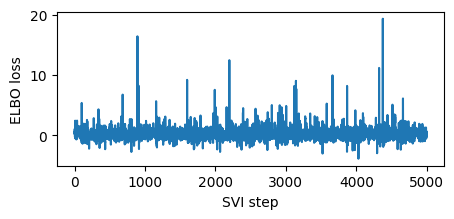

In [73]:
smoke_test = ('CI' in os.environ)

pyro.clear_param_store()

# These should be reset each training loop.
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(5000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(pkt_size, pkt_interval)
    losses.append(loss)
    if step % 100 == 0:
        print("Step: {}, Elbo loss: {}".format(step, loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

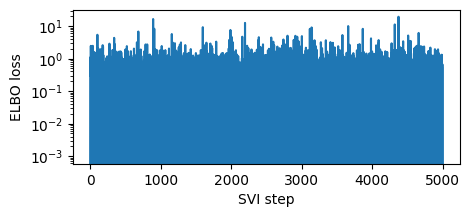

In [74]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [75]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.alpha -0.39921227
AutoNormal.scales.alpha 1.0625966
AutoNormal.locs.theta -0.38356182
AutoNormal.scales.theta 1.012074
AutoNormal.locs.mean_1 4.9607053
AutoNormal.scales.mean_1 1.9654489
AutoNormal.locs.sigma_1 0.018669313
AutoNormal.scales.sigma_1 0.05134025
AutoNormal.locs.mean_2 11.953664
AutoNormal.scales.mean_2 2.0159566
AutoNormal.locs.sigma_2 -0.003765365
AutoNormal.scales.sigma_2 1.7244132


In [89]:
res = []
for i in range(10000):
  predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=1)
  svi_samples = predictive(pkt_size, pkt_interval=None)

  gamma_samp = dist.Exponential(svi_samples['alpha'][0]).sample()
  gaussian_samp_1 = dist.Normal(svi_samples['mean_1'][0], svi_samples['sigma_1'][0]).sample()
  gaussian_samp_2 = dist.Normal(svi_samples['mean_2'][0], svi_samples['sigma_2'][0]).sample()
  cat_dist = dist.OneHotCategorical(torch.Tensor([0.9, 0.05, 0.05]))
  y = cat_dist.sample()
  res.append(y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2)

print(res)

[tensor(0.0343), tensor(0.1611), tensor(16.5011), tensor(0.0982), tensor(1.6617), tensor(14.7118), tensor(2.1578), tensor(3.7889), tensor(1.0922), tensor(0.8014), tensor(0.1196), tensor(0.8140), tensor(9.0497), tensor(3.4011), tensor(4.2590), tensor(0.3087), tensor(5.3405), tensor(0.7963), tensor(0.8509), tensor(0.2635), tensor(2.9918), tensor(0.2181), tensor(0.5912), tensor(0.2000), tensor(2.4994), tensor(0.6857), tensor(0.3586), tensor(0.7901), tensor(0.0272), tensor(0.1723), tensor(0.6973), tensor(0.0443), tensor(1.2771), tensor(1.3047), tensor(0.1615), tensor(0.1599), tensor(1.9123), tensor(1.4589), tensor(2.7273), tensor(0.1798), tensor(2.3198), tensor(4.2542), tensor(0.2691), tensor(8.9401), tensor(1.1998), tensor(0.6534), tensor(0.0458), tensor(7.6341), tensor(10.9004), tensor(4.5798), tensor(0.5272), tensor(2.9482), tensor(0.1309), tensor(1.0716), tensor(5.8925), tensor(0.0456), tensor(12.4680), tensor(0.5710), tensor(0.8954), tensor(1.9047), tensor(19.8931), tensor(0.4568), te

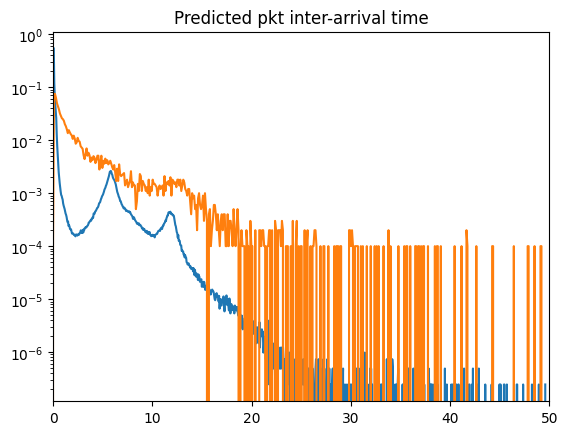

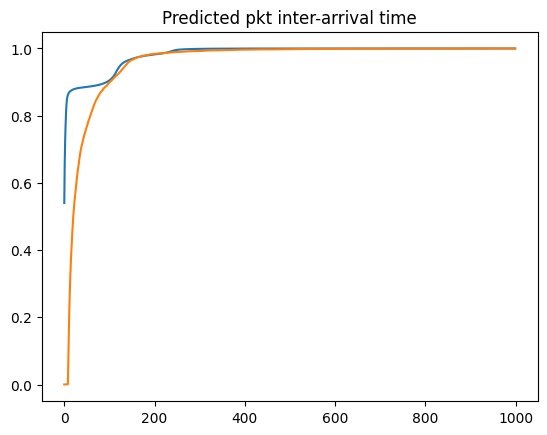

In [91]:
res = np.array(res)

res_count, res_bins_count = np.histogram(res, bins=1000) 
res_pdf = res_count / sum(res_count) 
res_cdf = np.cumsum(res_pdf) 

plt.figure()
plt.plot(dl_bins_count[1:], dl_pdf)
plt.yscale("log")
plt.title("Downlink pkt inter-arrival time")

# plt.figure()
plt.plot(res_bins_count[1:], res_pdf)
plt.xlim([0, 50])
plt.yscale("log")
plt.title("Predicted pkt inter-arrival time")

plt.figure()
plt.plot(dl_cdf)
# plt.yscale("log")
plt.title("Downlink pkt inter-arrival time")

# plt.figure()
plt.plot(res_cdf)
# plt.yscale("log")
plt.title("Predicted pkt inter-arrival time")

plt.show()